Необходимо разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

# Описание данных

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [1]:
#загружаем словарь для лемматизации текста
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 36.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
#Загружаем необходимые библиотеки

#библиотеки для работы с данными
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import random
#библиотеки для работы с текстом
import spacy
import en_core_web_md
from sklearn.feature_extraction.text import TfidfVectorizer

#работа с изображениями
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

#подготовка модели
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


#модели
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor

#настройка моделей
from sklearn.model_selection import GridSearchCV

#метрика
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

#работа с нейронной сетью
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.regularizers import l2

#CLIP
from sentence_transformers import SentenceTransformer
from sentence_transformers import util

In [3]:
#передаем словарь в переменную nlp
nlp = en_core_web_md.load()

Создаем константу, где отмечаем путь к файлам. Загружаем архив с данными. Распаковываем архив. Загружаем данные.

In [5]:
data_path = "dataset/to_upload"

In [ ]:
!wget https://....zip

In [7]:
!unzip -q dsplus_integrated_project_4.zip -d dataset/

In [8]:
train_df = pd.read_csv(os.path.join(data_path, "train_dataset.csv"))
crowd_annotation = pd.read_csv(os.path.join(data_path, "CrowdAnnotations.tsv"), sep='\t', header=None)
crowd_annotation.columns=[
    'image',
    'query_id',
    'possitive_part',
    'possitive_number',
    'negative_number'
]
expert_annotation = pd.read_csv(os.path.join(data_path, "ExpertAnnotations.tsv"), sep='\t', header=None)
expert_annotation.columns=[
    'image',
    'query_id',
    'expert_1',
    'expert_2',
    'expert_3'
]
test_df = pd.read_csv(os.path.join(data_path, "test_queries.csv"), sep='|')

In [9]:
test_images = pd.read_csv(os.path.join(data_path, 'test_images.csv'))

## Первичное исследование загруженных данных

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [10]:
train_df.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

В таблице train_df 5822 строки, пропущенных значений нет.

In [11]:
crowd_annotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             47830 non-null  object 
 1   query_id          47830 non-null  object 
 2   possitive_part    47830 non-null  float64
 3   possitive_number  47830 non-null  int64  
 4   negative_number   47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [12]:
crowd_annotation.head()

image                     query_id  possitive_part  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2             1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2             0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2             0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2             0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2             0.0   

   possitive_number  negative_number  
0                 3                0  
1                 0                3  
2                 0                3  
3                 0                3  
4                 0                3

В данных полученных с помощью краудсорсинга 47830 строк.

In [13]:
expert_annotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


In [14]:
expert_annotation.head()

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  
0         1  
1         2  
2         2  
3         2  
4         2

В данных с участием экспертов 5822 строки, столько же, сколько и в тренировочной выборке.

In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


In [16]:
test_df.head()

Unnamed: 0                     query_id  \
0           0  1177994172_10d143cb8d.jpg#0   
1           1  1177994172_10d143cb8d.jpg#1   
2           2  1177994172_10d143cb8d.jpg#2   
3           3  1177994172_10d143cb8d.jpg#3   
4           4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

В тестовой выборке находится 500 строк.

Данные загружены, теперь можно приступать к исследовательскому анализу данных.

Проверим количество уникальных изображений в тренировочной и тестовой выборках.

In [17]:
print(train_df['image'].nunique())
print(test_df['image'].nunique())

1000
100


В тренировочной выборке находится 1000 уникальных изображений.  
В тестовой выборке только 100 уникальных изображений.

Проверим количество уникальных запросов в тренировочной и тестовой выборках

In [18]:
print(train_df['query_id'].nunique())
print(test_df['query_id'].nunique())

977
500


В обучающей выборке 977 уникальных запросов, в тестовой выборке 500 уникальных запросов.

Далее оценим количество уникальных запросов в таблицвх с оценками.

In [19]:
print(expert_annotation['query_id'].nunique())
print(crowd_annotation['query_id'].nunique())

977
1000


В таблице с данными краудсорсинга больше уникальных запросов, чем в обучающей выборке. В таблице с данными экспертной оценки уникальных запросов столько же, сколько и в обучающей выборке.

Проверим дубликаты описаний и изображений между train и test

In [20]:
common_descriptions = set(train_df['query_id']).intersection(set(test_df['query_id']))
print(f"Число общих описаний: {len(common_descriptions)}")

common_images = set(train_df['image']).intersection(set(test_df['image']))
print(f"Число общих изображений: {len(common_images)}")

Число общих описаний: 0
Число общих изображений: 0


Проверим указывает ли одно и тоже описание всегда на одно и тоже изображение.

In [21]:
train_unique_pairs = train_df.groupby('query_id')['image'].nunique()
print(f"Описаний, соответствующих только одному изображению: {(train_unique_pairs == 1).sum()} из {len(train_unique_pairs)}")

Описаний, соответствующих только одному изображению: 61 из 977


In [22]:

test_unique_pairs = test_df.groupby('query_id')['image'].nunique()
print(f"Описаний, соответствующих только одному изображению (test): {(test_unique_pairs == 1).sum()} из {len(test_unique_pairs)}")

Описаний, соответствующих только одному изображению (test): 500 из 500


## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

### Агрегация оценок экспертов
Для агрегации оценок экспертов будем использовать медианное значение по трем оценкам. После этого полученные значения переведем в диапазон от 0 до 1.

In [23]:
def expert_annotation_median(row):
  return np.median([row['expert_1'], row['expert_2'], row['expert_3']])

In [24]:
expert_annotation['median_score'] = expert_annotation.apply(expert_annotation_median, axis=1)

In [25]:
expert_annotation.head()

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  median_score  
0         1           1.0  
1         2           1.0  
2         2           1.0  
3         2           2.0  
4         2           1.0

Получили медианное значение оценки. Теперь нормализуем значения от 0 до 1, используя минимум-максимум нормализацию.

In [26]:
expert_annotation['norm_med'] = (((expert_annotation['median_score'])-1)/3)

In [27]:
expert_annotation.head()

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  median_score  norm_med  
0         1           1.0  0.000000  
1         2           1.0  0.000000  
2         2           1.0  0.000000  
3         2           2.0  0.333333  
4         2           1.0  0.000000

In [28]:
crowd_annotation.head()

image                     query_id  possitive_part  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2             1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2             0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2             0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2             0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2             0.0   

   possitive_number  negative_number  
0                 3                0  
1                 0                3  
2                 0                3  
3                 0                3  
4                 0                3

### Агрегация оценок краудсорсинга

В качестве агрегации оценок краудсорсинга будем использовать готовый столбец possitive_part. Данный столбец представляет собой долю людей подтвердивших, что описание соответствует изображению от общего количества голосовавших за данное изображение.

### Объединение таблиц

При объединении таблиц сохраним оценки экспертов и краудсорсинга. Поэтому сначала к таблице с тренировочными данными присоединим таблицу с экспертной оценкой (количество значений совпадает), а потом присоединим все данные краудсорсинга. При объединении будем использовать совпадение по двум столбцам: название изображения (image_name) и id описания (description_id).

In [29]:
train_df_2 = train_df.merge(expert_annotation[['image', 'query_id', 'norm_med']], how='left', on=['image', 'query_id'])

In [30]:
train_final = train_df_2.merge(crowd_annotation[['image', 'query_id', 'possitive_part']], how='outer', on=['image', 'query_id'])

In [31]:
train_final.head()

image                     query_id query_text  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        NaN   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        NaN   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        NaN   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        NaN   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        NaN   

   norm_med  possitive_part  
0       NaN             1.0  
1       NaN             0.0  
2       NaN             0.0  
3       NaN             0.0  
4       NaN             0.0

In [32]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           51323 non-null  object 
 1   query_id        51323 non-null  object 
 2   query_text      5822 non-null   object 
 3   norm_med        5822 non-null   float64
 4   possitive_part  47830 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.0+ MB


Восстановим описания текстов, используя query_id.

In [33]:
train_final = train_final.drop(columns='query_text')\
    .merge(train_df[['query_id', 'query_text']].drop_duplicates(), on='query_id', how='left')

In [34]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           51323 non-null  object 
 1   query_id        51323 non-null  object 
 2   norm_med        5822 non-null   float64
 3   possitive_part  47830 non-null  float64
 4   query_text      50214 non-null  object 
dtypes: float64(2), object(3)
memory usage: 2.0+ MB


### Целевая переменная
Создадим целевую переменную. По условию задаче задано, что данные краудсорсинга менее точные, чем данные экспертной оценки. Для того, чтобы это учесть, введем веса для каждого типа оценки. Для экспертной оценки будем использовать вес 0.7, для краудсорсинга 0.3.

In [36]:
def score(row):
  if np.isnan(row['norm_med']):
    return row['possitive_part']
  elif np.isnan(row['possitive_part']):
    return row['norm_med']
  else:
    return row['norm_med']*0.7 + row['possitive_part']*0.3

train_final['target'] = train_final.apply(score, axis=1)

In [37]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           51323 non-null  object 
 1   query_id        51323 non-null  object 
 2   norm_med        5822 non-null   float64
 3   possitive_part  47830 non-null  float64
 4   query_text      50214 non-null  object 
 5   target          51323 non-null  float64
dtypes: float64(3), object(3)
memory usage: 2.3+ MB


Теперь удалим лишние столбцы norm_med, possitive_part. После этого удалим строки, с пропусками qury_text.

In [38]:
train_final = train_final.drop(columns=['norm_med', 'possitive_part'])

In [39]:
train_final = train_final.dropna()

In [40]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50214 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       50214 non-null  object 
 1   query_id    50214 non-null  object 
 2   query_text  50214 non-null  object 
 3   target      50214 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


В итоговой таблице осталось 4 столбца: изображение, id описания изображения, описание изображения и целевая переменная. Всего 50214 значений.

Посмотрим на распределение целевой переменной.

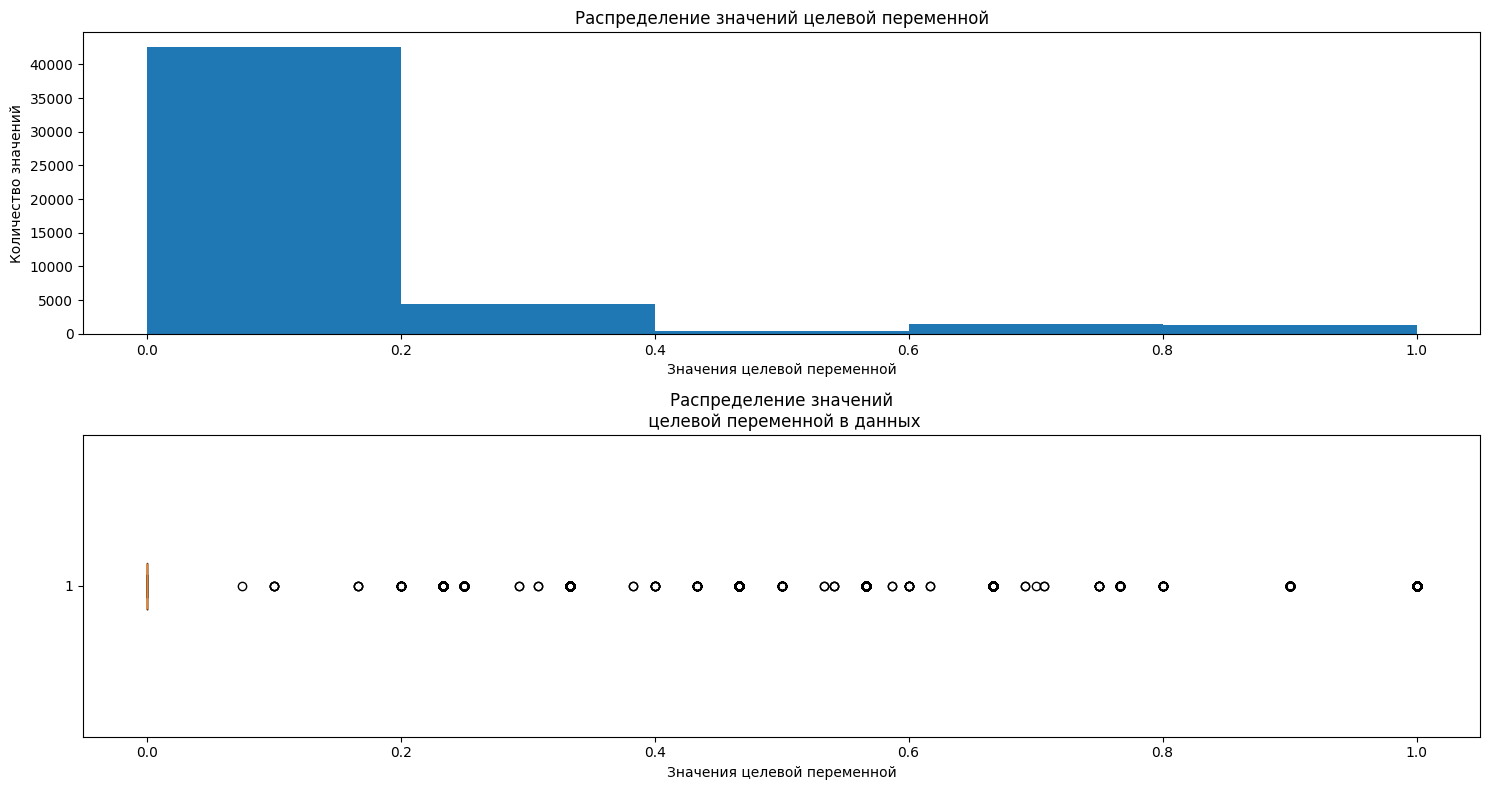

In [41]:
fig, ax = plt.subplots(2,1, figsize=(15, 8))
ax[0].hist(train_final['target'], bins=5)
ax[0].set_xlabel('Значения целевой переменной')
ax[0].set_ylabel('Количество значений')
ax[0].set_title('Распределение значений целевой переменной')
ax[1].boxplot(train_final['target'], vert=False)
ax[1].set_xlabel('Значения целевой переменной')
ax[1].set_title('Распределение значений\n целевой переменной в данных')
plt.tight_layout()
plt.show()

В данных большой перекос значений целевой переменной. Большая часть данных приходится на значения от 0 до 0.2, т.е. на очень низкие значения соответствия изображения описанию.

Выведим несколько фотографий из тренировочной выборки, комментарии к ним и оценку

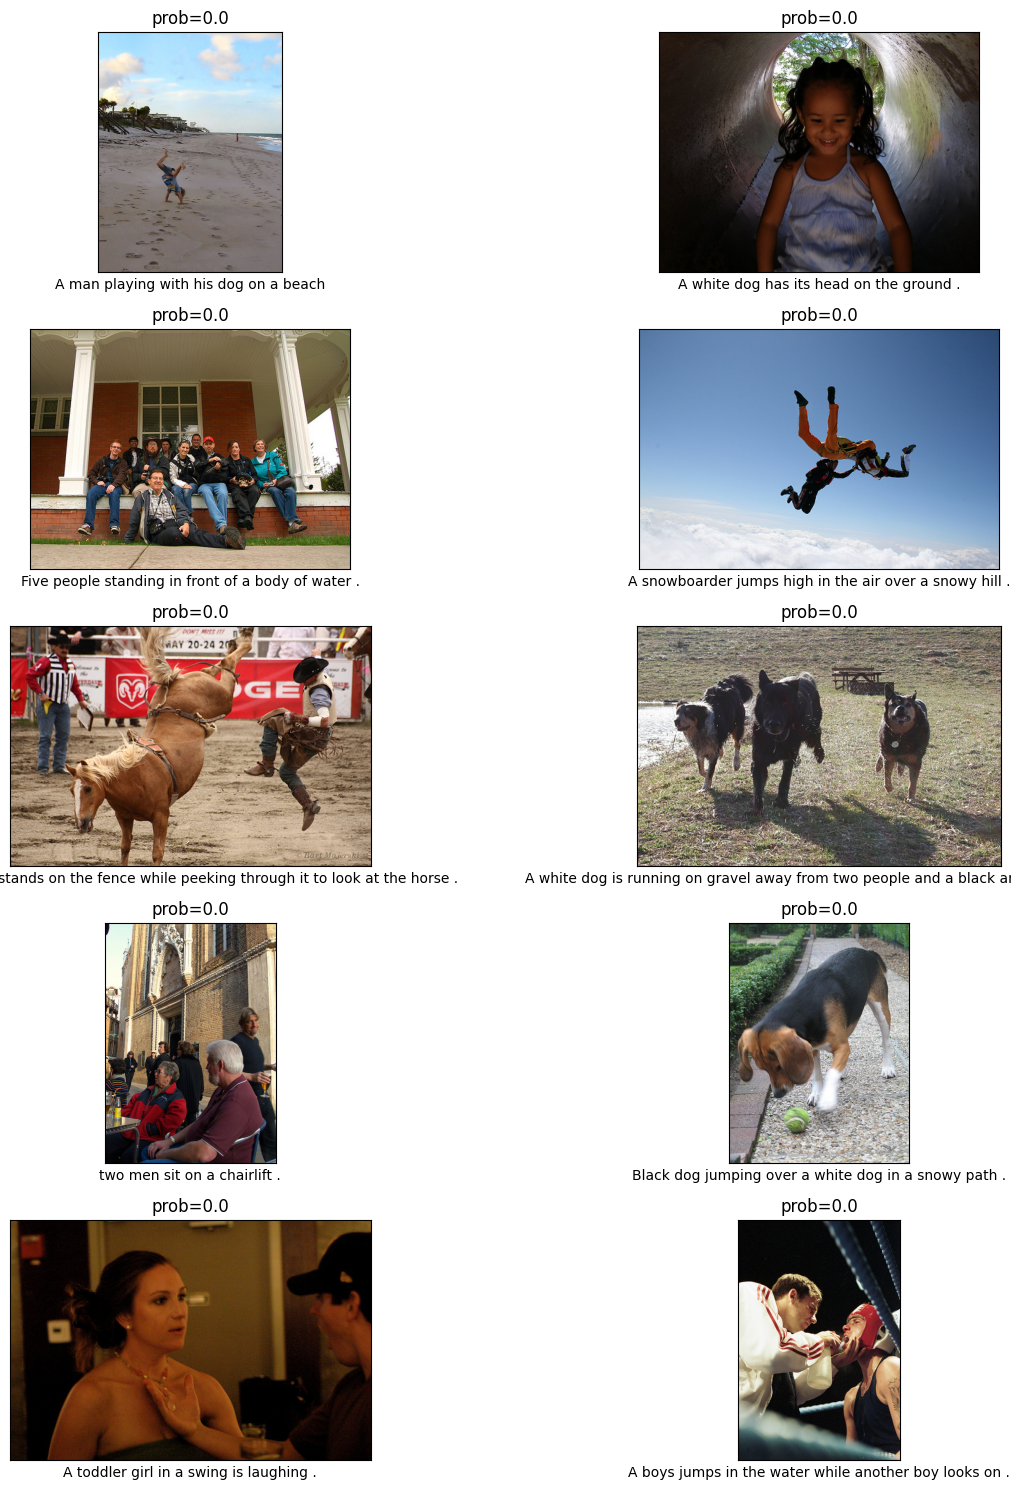

In [42]:
sample_photo = train_final.sample(n=10)

fig = plt.figure(figsize=(15,15))

for i in range(10):
  row = sample_photo.iloc[i]
  ax = fig.add_subplot(5, 2, i+1)
  img_name = row['image']
  img_text = row['query_text']
  score = row['target']
  img_path = os.path.join(data_path, 'train_images', img_name)
  img = mpimg.imread(img_path)

  ax.imshow(img)
  ax.set_title(f'prob={score}')
  ax.set_xlabel(img_text)
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()


## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Перед началом фильтрации текста проведем лемматизацию текста для того, чтобы исключить перечисление единственного и множественного числа в словаре.

In [43]:
# перед фильтрацией переведем все буквы в query_text в нижни регистр
train_final['query_text'] = train_final['query_text'].str.lower()

In [44]:
train_final.sample(10)

image                     query_id  \
33031  3320356356_1497e53f80.jpg  3100251515_c68027cc22.jpg#2   
15461  2577972703_a22c5f2a87.jpg  2120383553_5825333a3f.jpg#2   
12034  2435685480_a79d42e564.jpg  2207244634_1db1a1890b.jpg#2   
16685  2623930900_b9df917b82.jpg  3503689049_63212220be.jpg#2   
21519  2894217628_f1a4153dca.jpg  1461667284_041c8a2475.jpg#2   
26113  3095225232_2e6e6dc92e.jpg  3571147934_d1c8af1d6e.jpg#2   
35317  3406930103_4db7b4dde0.jpg  2938120171_970564e3d8.jpg#2   
51149    96420612_feb18fc6c6.jpg  3217266166_4e0091860b.jpg#2   
49496    56489627_e1de43de34.jpg  3320356356_1497e53f80.jpg#2   
36367  3439382048_d2e23b2b4c.jpg  2893374123_087f98d58a.jpg#2   

                                              query_text    target  
33031  a large " green " peaceful protest is taken to...  0.000000  
15461  a little girl in a green outfit wringing out a...  0.000000  
12034  the helmeted boy is doing a stunt on a skatebo...  0.000000  
16685        a young man wearing dark sunglasses smiling  0.000000  
21519     a man in a white hat plays guitar on a stage .  0.000000  
26113  kids are waiting at the bottom of a staircase ...  0.333333  
35317        two dogs are standing together on a patio .  0.000000  
51149   two small children are twirling sparkling rope .  0.000000  
49496                a man scales a rock in the forest .  0.000000  
36367  a man riding a blue motorcycle jumps over a ra...  0.000000

### Лемматизация текста

Для лемматизации будем использовать библиотеку spacy.

In [21]:
# создаем функцию для лемматизации текста

def lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])

In [46]:
tqdm.pandas()
train_final['lemmatized_query_text'] = train_final['query_text'].progress_apply(lemmatize)

100%|██████████| 50214/50214 [05:28<00:00, 152.80it/s]


In [47]:
train_final.sample(20)

image                     query_id  \
33297  3333921867_6cc7d7c73d.jpg   327415627_6313d32a64.jpg#2   
28161  3167365436_c379bda282.jpg  2309860995_c2e2a0feeb.jpg#2   
10206  2317714088_bcd081f926.jpg  3364151356_eecd07a23e.jpg#2   
34663  3384314832_dffc944152.jpg   493621130_152bdd4e91.jpg#2   
42223  3619416477_9d18580a14.jpg  3245460937_2710a82709.jpg#2   
38804  3518126579_e70e0cbb2b.jpg   670609997_5c7fdb3f0b.jpg#2   
26686  3114944484_28b5bb9842.jpg  2317714088_bcd081f926.jpg#2   
46450   461505235_590102a5bf.jpg  3301859683_2d5e4b40a3.jpg#2   
3177   1461667284_041c8a2475.jpg  3354883962_170d19bfe4.jpg#2   
47111   488356951_b3b77ad832.jpg  3503623999_bbd5dcfb18.jpg#2   
14248  2518508760_68d8df7365.jpg   391579205_c8373b5411.jpg#2   
29716  3217620013_8b17873273.jpg  3354330935_de75be9d2f.jpg#2   
11591   241347204_007d83e252.jpg  2876993733_cb26107d18.jpg#2   
35845  3427233064_6af01bfc5c.jpg  2932740428_b15384f389.jpg#2   
16300  2607462776_78e639d891.jpg  3004823335_9b82cbd8a7.jpg#2   
9270   2271755053_e1b1ec8442.jpg  2251747182_6b67a3ab8b.jpg#2   
14019  2502905671_c6039804ab.jpg  2844641033_dab3715a99.jpg#2   
45651   422763475_0bc814dac6.jpg   384577800_fc325af410.jpg#2   
35463  3413571342_b9855795e2.jpg  3631986552_944ea208fc.jpg#2   
17036  2647049174_0fb47cee2e.jpg  2475162978_2c51048dca.jpg#2   

                                              query_text    target  \
33297                     two dogs run through a field .  0.333333   
28161  a woman wears sunglasses and a black coat as s...  0.000000   
10206  a light brown dog runs happily by a green fence .  0.000000   
34663   a dog wearing a collar jumping from a platform .  0.000000   
42223                a child jumping on a tennis court .  0.000000   
38804  a black dog jumps for a frisbee in a backyard ...  0.000000   
26686                     people stand outside a house .  0.000000   
46450                           a person skis downhill .  0.000000   
3177      a white dog runs past a fence on a snowy day .  0.000000   
47111  a woman wearing a hat and red scarf stands amo...  0.000000   
14248          an airborne dog on a leash with a woman .  0.000000   
29716  a skier is being filmed by a man with video ca...  0.000000   
11591  two lonely fans in green ponchos sit in a stad...  0.000000   
35845  a motorcyclist wearing a red and white jacket ...  0.000000   
16300             a dog in a grassy field , looking up .  0.000000   
9270   a young boy , playing basketball , is getting ...  1.000000   
14019                          a boy plays in the sand .  0.000000   
45651  a sheltie dog carries a white-colored toy in i...  0.000000   
35463                       a surfer in water and foam .  1.000000   
17036  a woman holding a small ball chasing after a s...  0.000000   

                                   lemmatized_query_text  
33297                        two dog run through a field  
28161  a woman wear sunglass and a black coat as she ...  
10206     a light brown dog run happily by a green fence  
34663           a dog wear a collar jump from a platform  
42223                     a child jump on a tennis court  
38804  a black dog jump for a frisbee in a backyard w...  
26686                       people stand outside a house  
46450                              a person ski downhill  
3177         a white dog run past a fence on a snowy day  
47111  a woman wear a hat and red scarf stand among o...  
14248            an airborne dog on a leash with a woman  
29716  a skier be be film by a man with video camera ...  
11591   two lonely fan in green ponchos sit in a stadium  
35845  a motorcyclist wear a red and white jacket pop...  
16300                    a dog in a grassy field look up  
9270   a young boy play basketball be get ready to ta...  
14019                             a boy play in the sand  
45651  a sheltie dog carry a white colored toy in its...  
35463                         a surfer in water and foam  
17036  a w

Приступим к фильтрации. Создадим словарь. Далее проверим содержимое текстов. Важно учесть, что одному изображению может соответствовать несколько описаний.

In [23]:
# создадим словарь, по которому будет происходить фильтрация описания изображения
keywords_dic = {
    'baby',
    'toddler',
    'child',
    'children',
    'childhood',
    'kid',
    'teenager',
    'adolescent',
    'newborn',
    'infant',
    'girl',
    'boy'
}

In [49]:
# создаем функцию для проверки слов в строке на соответствие словарю
def keywords_check(text, keywords):
    words = set(text.split())
    return not words.isdisjoint(keywords)

In [50]:
# сделаем копию таблице для того, чтобы было проще отстраивать код
train_final_2 = train_final.copy()

In [51]:
# находим строки с запрещенными словами
train_final_2['with_ban_keyword'] = train_final_2['lemmatized_query_text'].apply(lambda x: keywords_check(x, keywords_dic))

In [52]:
# находим все id, для которых есть запрещенные слова
query_ids_with_ban_keywords = train_final_2.loc[train_final_2['with_ban_keyword'], 'query_id'].unique()

In [53]:
# удаляем строки связанные с этим id
train_ban = train_final_2[train_final_2['query_id'].isin(query_ids_with_ban_keywords)]

In [54]:
train_ban.head()

image                     query_id  \
1   1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   
2   1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   
10  1056338697_4f7d7ce270.jpg  2436081047_bca044c1d3.jpg#2   
11  1056338697_4f7d7ce270.jpg  2490768374_45d94fc658.jpg#2   
12  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   

                                           query_text    target  \
1           a boy in glasses is wearing a red shirt .  0.000000   
2    a young boy holds onto a blue handle on a pier .  0.000000   
10  a little girl wearing a pink shirt jumps off a...  0.000000   
11                 a young girl wearing blue smiles .  0.333333   
12  a young child is wearing blue goggles and sitt...  0.000000   

                                lemmatized_query_text  with_ban_keyword  
1                  a boy in glass be wear a red shirt              True  
2       a young boy hold onto a blue handle on a pier              True  
10   a little girl wear a pink shirt jump off a swing              True  
11                       a young girl wear blue smile              True  
12  a young child be wear blue goggle and sit in a...              True

In [55]:
# удаляем два последних символа, чтобы получить название рисунка
train_ban['query_id'] = train_ban['query_id'].map(lambda x: str(x)[:-2])
# создаем список запрещенных картинок, которые нужно удалить
ban_images = train_ban['query_id'].unique()

<ipython-input-55-a3e91730ed18>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ban['query_id'] = train_ban['query_id'].map(lambda x: str(x)[:-2])


In [56]:
# вычищаем изображения
train_clear = train_final_2[train_final_2['image'].isin(ban_images) == False]

In [57]:
train_clear.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35842 entries, 0 to 51322
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   image                  35842 non-null  object 
 1   query_id               35842 non-null  object 
 2   query_text             35842 non-null  object 
 3   target                 35842 non-null  float64
 4   lemmatized_query_text  35842 non-null  object 
 5   with_ban_keyword       35842 non-null  bool   
dtypes: bool(1), float64(1), object(4)
memory usage: 1.7+ MB


In [58]:
# удалим лишние столбцы
train_clear.drop(columns=['with_ban_keyword', 'query_text'], inplace=True)

<ipython-input-58-becf693eff66>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_clear.drop(columns=['with_ban_keyword', 'query_text'], inplace=True)


In [59]:
train_clear.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35842 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   image                  35842 non-null  object 
 1   query_id               35842 non-null  object 
 2   target                 35842 non-null  float64
 3   lemmatized_query_text  35842 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.4+ MB


In [60]:
train_clear.sample(10)

image                     query_id    target  \
32673  3295680663_af21ea648b.jpg  3558370311_5734a15890.jpg#2  0.000000   
43838  3701291852_373ea46bb6.jpg   160792599_6a7ec52516.jpg#2  0.000000   
30096  3223055565_68973f5d20.jpg   189721896_1ffe76d89e.jpg#2  0.000000   
14431  2526041608_a9775ab8d7.jpg  2511019188_ca71775f2d.jpg#2  0.000000   
43597  3692892751_f6574e2700.jpg  2339106348_2df90aa6a9.jpg#2  0.000000   
41676  3602838407_bf13e49243.jpg  1772859261_236c09b861.jpg#2  0.666667   
25560  3070031806_3d587c2a66.jpg  2480850054_de3433b54a.jpg#2  0.000000   
1111   1258913059_07c613f7ff.jpg   324208502_674488bcea.jpg#2  0.000000   
4839   1786425974_c7c5ad6aa1.jpg  3154641421_d1b9b8c24c.jpg#2  0.000000   
6186   2083434441_a93bc6306b.jpg  3530843182_35af2c821c.jpg#2  0.000000   

                                   lemmatized_query_text  
32673  a man in midair do a bicycle stunt on a half pipe  
43838      five people stand in front of a body of water  
30096  a young man climb a mountain another follow below  
14431  two dark colored dog romp in the grass with a ...  
43597                           the girl be in the crowd  
41676                     a dog splash through the water  
25560                   a dirty boy run through the dirt  
1111   a person sit on a red bench to eat while anoth...  
4839        a black man play basketball with orange shoe  
6186   a man with sunglass and a woman with a hat be ...

In [61]:
train_clear['image'].nunique()

710

После фильтрации данных в таблице осталось 35842 значения. Пропущенных значений нет.
Текст лемматизирован.
Осталось 710 уникальных изображений из 1000.
Далее можно приступать к векторизации изображений и текстов.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Воспользуемся советом и будем использовать ResNet-18, при этом оставляем слои модели до последнего классификатора, это должно дать на выходе вектор размерность 512.  
Кроме того, так как у нас всего 710 уникальных изображений, нет смысла векторизовать все 30 тыс.

In [62]:
def get_image_embeddings(image_paths, image_folder):
    # Загрузка модели ResNet18
    resnet18 = models.resnet18(pretrained=True)
    for param in resnet18.parameters():
        param.requires_grad_(False)  # Замораживаем веса

    # Оставляем только части модели до последнего полносвязного слоя
    # Мы будем использовать последний слой перед слоем классификации
    resnet18 = nn.Sequential(*list(resnet18.children())[:-1])  # Убираем последний слой
    resnet18.eval()  # Переводим в режим предсказания

    # Препроцессинг
    norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        norm,
    ])

    embeddings = {}
    unique_images = set(image_paths)  # Получаем уникальные изображения

    # Проходим по всем уникальным изображениям
    for filename in tqdm(unique_images):
        # Загружаем и обрабатываем изображение
        path = os.path.join(image_folder, filename)
        img = Image.open(path).convert('RGB')
        image_tensor = preprocess(img).unsqueeze(0)  # Добавляем batch dimension

        with torch.no_grad():
            output_tensor = resnet18(image_tensor)  # Получаем эмбеддинг до полносвязных слоёв
            output_tensor = output_tensor.flatten()  # Делаем выравнивание

        embeddings[filename] = output_tensor.numpy()

    # Преобразуем эмбеддинги обратно в массив для всех изображений в списке
    all_embeddings = []
    for filename in image_paths:
        all_embeddings.append(embeddings[filename])

    all_embeddings = np.stack(all_embeddings)

    return all_embeddings

In [63]:
# Путь к папке с изображениями
image_path = os.path.join(data_path, "train_images")
# Получаем эмбеддинги для всех изображений из столбца 'image' в train_clean
image_embeddings = get_image_embeddings(train_clear['image'], image_path)

# Размерность эмбеддингов
image_embeddings.shape

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]
100%|██████████| 710/710 [00:46<00:00, 15.38it/s]


(35842, 512)

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

tf-idf
word2vec
*трансформеры (например Bert)
* — если вы изучали трансформеры в спринте Машинное обучение для текстов.

Так как я уже начал использовать библиотеку spacy для лемматизации текста, воспользуемся этой же библиотекой для векторизации лемматизированного текста.

In [16]:
# функция для векторизации текста
def vectorize_text(text):
  doc = nlp(text)
  return doc.vector

In [65]:
tqdm.pandas()
train_clear['text_vector'] = train_clear['lemmatized_query_text'].progress_apply(vectorize_text)
text_embeddings = np.vstack(train_clear['text_vector'].values)

100%|██████████| 35842/35842 [03:40<00:00, 162.38it/s]
<ipython-input-65-5df63ce6e42a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_clear['text_vector'] = train_clear['lemmatized_query_text'].progress_apply(vectorize_text)


In [66]:
len(text_embeddings)

35842

In [67]:
len(text_embeddings[0])

300

Для текстов получены вектора размерностью 300.

## 5. Объединение данных для подачи в модель

In [68]:
X = np.concatenate([image_embeddings, text_embeddings], axis=1)
y = train_clear['target'].values

In [69]:
# проверим типы
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [70]:
# проверим размерности
print(X.shape)
print(y.shape)

(35842, 812)
(35842,)


## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

В данном случае обучение модели подразумевает решение задачи регрессии. Наиболее подходящими метриками могут послужить RMSE, MAE, MSE, R^2. Будем использовать RMSE, что покажет, насколько сильно предсказанные вероятности модели отклоняются от истинных.  
При разделении данных будем использовать GroupShuffleSplit. Правда у такого способа есть минус, при разбиении он не учитывает перекос целевой переменной в сторону низких значений.   
Протестируем несколько моделей. Начнем с построения pipeline для более простых моделей, используя перебор гиперпараметров и обучение на кроссвалидации. После этого обучим нейронную сеть.
Будем использовать следующие модели:  
LinearRegression.  
SVR.  
DecisionTreeRegressor.  
LGBMRegressor

In [71]:
RANDOM_STATE = 42
# разобъем данные на тестовую и валидационную выборки
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=RANDOM_STATE)
train_indices, val_indices = next(gss.split(X, y, groups=train_clear['image'].values))
X_train, X_val = X[train_indices], X[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

Перед построением pipeline и перебора гиперпараметров проверим, какой результат покажет базовая модель DummyRegressor, стратегию заполнения медианой. Данная стратегия выбрана, так как в распределении целевой переменной явный перекос в сторону низких значений.

In [72]:
dummy_regressor = DummyRegressor(strategy='median')

In [73]:
dummy_regressor.fit(X_train, y_train)
y_pred = dummy_regressor.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print(rmse)

0.23576920161921458


Значение RMSE на dummy модели составляет 0.236 ~~0.129~~, т.е. модель в своей оценке ошибается на 0.236 ~~0.129~~.
Таким образом, нам необходимо, чтобы более сложные модели показали значения ниже 0.236 ~~0.129~~.

Перейдем к построению более сложных моделей.

In [74]:
# создаем пайалайн
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('models', LinearRegression())
])
# создаем словари для моделей
param_grid = [
    {
        'models': [LinearRegression()]

    },
    {
        'models': [SVR()],
        'models__kernel': ['rbf'],
        'models__C': [1, 5]
   },
   {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth':[5, 10, 20],
        'models__min_samples_split': [10, 50, 100]
   },
   {
        'models':[LGBMRegressor(random_state=RANDOM_STATE)],
        'models__num_leaves': [30, 60],
        'models__max_depth': [8, 12],
        'models__learning_rate': [0.05, 0.1],
   }
]

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring ='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    error_score='raise'
)
grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)
print('Лучшие гиперпараметры модели:', grid_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Лучшая модель и её параметры:

 Pipeline(steps=[('scaler', StandardScaler()), ('models', SVR(C=1))])
Метрика лучшей модели на тренировочной выборке: -0.20387679811561488
Лучшие гиперпараметры модели: {'models': SVR(), 'models__C': 1, 'models__kernel': 'rbf'}


In [75]:
model_result = pd.DataFrame(grid_search.cv_results_)
model_result['model'] = model_result['param_models'].apply(lambda x: str(x).split('(')[0])
results_by_model = model_result.groupby('model').agg({
    'mean_test_score': 'max',
    'params': 'first'
}).reset_index().sort_values(by='mean_test_score', ascending=False)
results_by_model

model  mean_test_score  \
3                    SVR        -0.203877   
1          LGBMRegressor        -0.207291   
0  DecisionTreeRegressor        -0.218332   
2       LinearRegression        -0.231860   

                                              params  
3  {'models': SVR(), 'models__C': 1, 'models__ker...  
1  {'models': LGBMRegressor(random_state=42), 'mo...  
0  {'models': DecisionTreeRegressor(random_state=...  
2                     {'models': LinearRegression()}

Лучший результат на кросс-валидации показала модель SVR ~~LGBMRegressor~~, значение метрики составило 0.204 ~~0.115~~, что незначительно лучше базовой модели.

Проверим лучшую модель на валидационной выборке

In [76]:
y_val_pred = grid_search.best_estimator_.predict(X_val)
RMSE = root_mean_squared_error(y_val, y_val_pred)
print(RMSE)

0.20176931382085184


На валидационной выборке лучшая модель показала результат 0.202. Результат почти совпадает с результатом на кросс-валидации

## Модель нейронной сети V.1
Далее разработаем модель нейронной сети. Для организации модели будем использовать библиотеку keras.

In [81]:
# перед обучением отмасштабируем данные.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
198/198 - 11s - 55ms/step - loss: 0.8167 - root_mean_squared_error: 0.9037 - val_loss: 0.1108 - val_root_mean_squared_error: 0.3329
Epoch 2/50
198/198 - 1s - 5ms/step - loss: 0.7253 - root_mean_squared_error: 0.8516 - val_loss: 0.1130 - val_root_mean_squared_error: 0.3361
Epoch 3/50
198/198 - 1s - 5ms/step - loss: 0.6335 - root_mean_squared_error: 0.7959 - val_loss: 0.0987 - val_root_mean_squared_error: 0.3142
Epoch 4/50
198/198 - 1s - 5ms/step - loss: 0.5757 - root_mean_squared_error: 0.7587 - val_loss: 0.0852 - val_root_mean_squared_error: 0.2919
Epoch 5/50
198/198 - 1s - 6ms/step - loss: 0.5047 - root_mean_squared_error: 0.7104 - val_loss: 0.0777 - val_root_mean_squared_error: 0.2787
Epoch 6/50
198/198 - 1s - 7ms/step - loss: 0.4545 - root_mean_squared_error: 0.6742 - val_loss: 0.0699 - val_root_mean_squared_error: 0.2644
Epoch 7/50
198/198 - 1s - 5ms/step - loss: 0.4312 - root_mean_squared_error: 0.6567 - val_loss: 0.0651 - val_root_mean_squared_error: 0.2551
Epoch 8/50


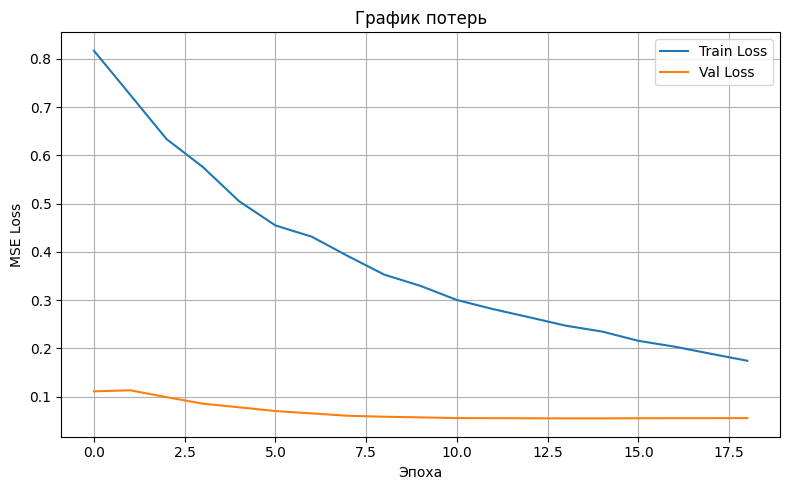

In [82]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

tf.random.set_seed(RANDOM_STATE)
# создаем модель
neural_n = Sequential()
# первый слой
neural_n.add(Dense(2048, input_shape=(X.shape[1],), activation='relu'))
# нормализация
neural_n.add(BatchNormalization())
neural_n.add(Dropout(0.5))
# второй слой
neural_n.add(Dense(1024, activation='relu'))
neural_n.add(BatchNormalization())
neural_n.add(Dropout(0.5))
# третий слой
neural_n.add(Dense(512, activation='relu'))
neural_n.add(Dropout(0.5))
neural_n.add(BatchNormalization())
# последний слой с одним выводом так как регрессия + ReLU убираем отрицательные значения в предсказаниях
neural_n.add(Dense(1, activation='relu'))

neural_n.compile(optimizer = Adam(learning_rate = 0.00001),
              loss='mean_squared_error',
              metrics=[RootMeanSquaredError()])
# обучение
history = neural_n.fit(X_train_scaled,
             y_train,
             validation_data=(X_val_scaled, y_val),
             epochs=50,
             batch_size=128,
             verbose=2,
             shuffle=True,
             callbacks=[early_stop])

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('График потерь')
plt.xlabel('Эпоха')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Нейронная модель, по-видимому, достигла локального минимума. Начиная с 11 эпохи метрика качества не меняется. На обучающей выборке модель достигла значения 0.0161, в то время как на валидационной выборке значение составило 0.129, что сопоставимо с базовой моделью.

## Модель нейронной сети V.2

Epoch 1/50
198/198 - 10s - 50ms/step - loss: 0.8379 - root_mean_squared_error: 0.9154 - val_loss: 0.3377 - val_root_mean_squared_error: 0.5811
Epoch 2/50
198/198 - 4s - 18ms/step - loss: 0.7134 - root_mean_squared_error: 0.8446 - val_loss: 0.3303 - val_root_mean_squared_error: 0.5747
Epoch 3/50
198/198 - 1s - 5ms/step - loss: 0.6489 - root_mean_squared_error: 0.8055 - val_loss: 0.2658 - val_root_mean_squared_error: 0.5156
Epoch 4/50
198/198 - 1s - 5ms/step - loss: 0.5690 - root_mean_squared_error: 0.7543 - val_loss: 0.2180 - val_root_mean_squared_error: 0.4669
Epoch 5/50
198/198 - 1s - 5ms/step - loss: 0.5232 - root_mean_squared_error: 0.7233 - val_loss: 0.1862 - val_root_mean_squared_error: 0.4315
Epoch 6/50
198/198 - 1s - 5ms/step - loss: 0.4750 - root_mean_squared_error: 0.6892 - val_loss: 0.1545 - val_root_mean_squared_error: 0.3931
Epoch 7/50
198/198 - 1s - 6ms/step - loss: 0.4340 - root_mean_squared_error: 0.6588 - val_loss: 0.1252 - val_root_mean_squared_error: 0.3538
Epoch 8/50

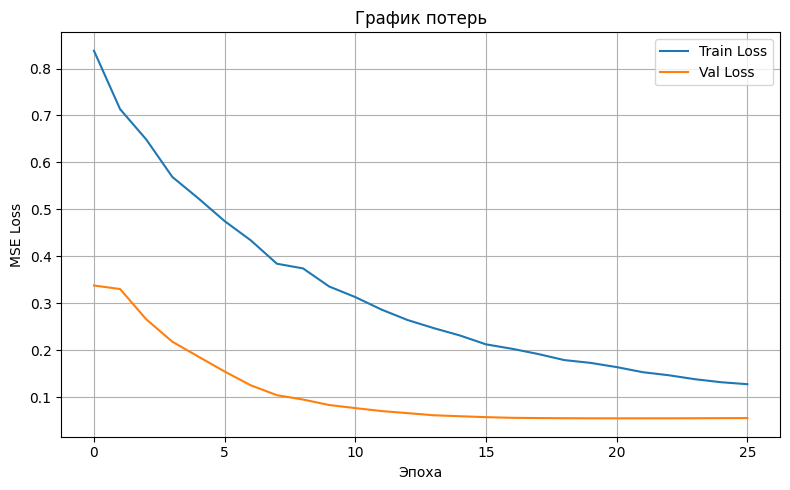

In [83]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

tf.random.set_seed(RANDOM_STATE)
# создаем модель
neural_n = Sequential()
# первый слой
neural_n.add(Dense(2048, input_shape=(X.shape[1],), activation='relu'))
# нормализация
neural_n.add(BatchNormalization())
neural_n.add(Dropout(0.5))
# второй слой
neural_n.add(Dense(1024, activation='relu'))
neural_n.add(BatchNormalization())
neural_n.add(Dropout(0.5))
# третий слой
neural_n.add(Dense(512, activation='relu'))
neural_n.add(Dropout(0.5))
neural_n.add(BatchNormalization())
# последний слой с одним выводом так как регрессия + ReLU убираем отрицательные значения в предсказаниях
neural_n.add(Dense(1, activation='relu'))

neural_n.compile(optimizer = Adam(learning_rate = 0.00001),
              loss='mean_squared_error',
              metrics=[RootMeanSquaredError()])
# обучение
history = neural_n.fit(X_train,
             y_train,
             validation_data=(X_val, y_val),
             epochs=50,
             batch_size=128,
             verbose=2,
             shuffle=True,
             callbacks=[early_stop])

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('График потерь')
plt.xlabel('Эпоха')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Результат второй модели, без стандартизации такой же. Попробуем сделать еще одну модель.

Epoch 1/50
99/99 - 10s - 105ms/step - loss: 1.2869 - root_mean_squared_error: 1.1344 - val_loss: 0.1282 - val_root_mean_squared_error: 0.3580
Epoch 2/50
99/99 - 1s - 7ms/step - loss: 1.1912 - root_mean_squared_error: 1.0914 - val_loss: 0.2594 - val_root_mean_squared_error: 0.5093
Epoch 3/50
99/99 - 1s - 6ms/step - loss: 1.1633 - root_mean_squared_error: 1.0786 - val_loss: 0.3434 - val_root_mean_squared_error: 0.5860
Epoch 4/50
99/99 - 1s - 6ms/step - loss: 1.1107 - root_mean_squared_error: 1.0539 - val_loss: 0.3858 - val_root_mean_squared_error: 0.6211
Epoch 5/50
99/99 - 1s - 6ms/step - loss: 1.0834 - root_mean_squared_error: 1.0409 - val_loss: 0.4032 - val_root_mean_squared_error: 0.6350
Epoch 6/50
99/99 - 1s - 6ms/step - loss: 1.0320 - root_mean_squared_error: 1.0159 - val_loss: 0.4074 - val_root_mean_squared_error: 0.6383
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


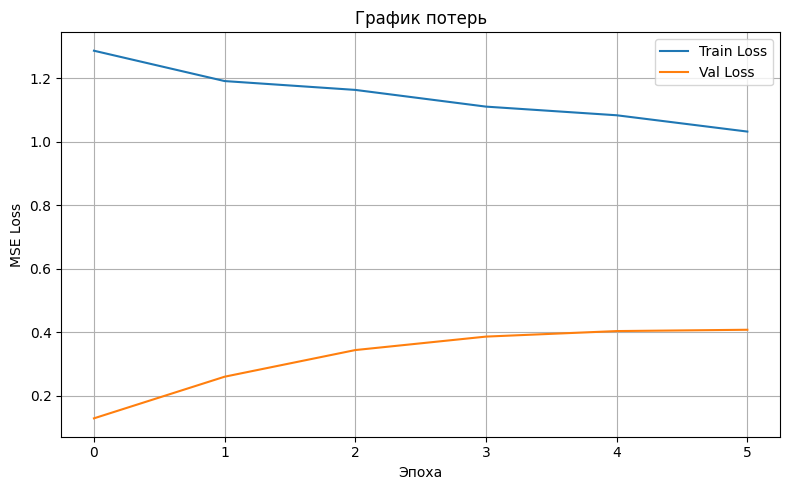

In [84]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

tf.random.set_seed(RANDOM_STATE)

# Создание модели
neural_n = Sequential()
neural_n.add(Dense(2048, input_shape=(X.shape[1],), activation='relu'))
neural_n.add(BatchNormalization())
neural_n.add(Dropout(0.3))

neural_n.add(Dense(1024, activation='relu'))
neural_n.add(BatchNormalization())
neural_n.add(Dropout(0.3))

neural_n.add(Dense(512, activation='relu'))
neural_n.add(BatchNormalization())
neural_n.add(Dropout(0.3))

# Выходной слой
neural_n.add(Dense(1, activation='relu'))

# Компиляция
neural_n.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss='mean_squared_error',
    metrics=[RootMeanSquaredError()]
)

# Обучение
history = neural_n.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    verbose=2,
    shuffle=True,
    callbacks=[early_stop]
)

# Визуализация
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('График потерь')
plt.xlabel('Эпоха')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Вывод:
Было протестировано 5 моделей:  
* LinearRegression  
* SVR  
* DecisionTreeRegressor  
* LGBMRegressor
* Нейронная сеть
Лучший результат на валидационной выборке показала модель SVR ~~LGBMRegressor~~, значение метрики составило 0.202, что чуть лучше базовой модели.
Для тестирования будем использовать эту модель.


## 7. Тестирование модели

Для того, чтобы протестировать модель создадим следующую функцию:
Функция получает текст - возвращает картинку к нему и метрику близости. Если запрос не корректен функция выдает предупреждение.  
Соответственно функция должна векторизовать полученный текст, далее с помощью модели получить предсказание для 100 пар (вектор описания и вектор изображения), далее выводим пару текст-картинка, где модель покажет максимальную метрику.

Применим эту функцию к 10 случайным запросам.

In [77]:
test_image_path = os.path.join(data_path, "test_images")
test_image_embeddings = get_image_embeddings(test_df['image'].unique(), test_image_path)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 100/100 [00:06<00:00, 16.57it/s]


In [78]:
test_image_embeddings.shape

(100, 512)

In [79]:
# Функция, которая выводит наиболее релевантные изображения по текстовому запросу
def show_picture(text):
    # Лемматизация текста
    lemmatized = lemmatize(text)
    # Проверка на запрещенные слова
    if any(word in keywords_dic for word in lemmatized.split()):
        print('This image is unavailable in your country in compliance with local laws.')
        return
    # Векторизация текста
    test_text_embeddings = vectorize_text(lemmatized)
    # Повторяем вектор текста для всех уникальных изображений (100 изображений)
    test_text_emb_array = np.tile(test_text_embeddings, (test_image_embeddings.shape[0], 1))
    # Конкатенируем вектора всех ихображений с ветором текста описания и переводим в тензор
    X_test = np.concatenate([test_image_embeddings, test_text_emb_array], axis=1)
    # Получаем предсказания
    y_test_pred = grid_search.best_estimator_.predict(X_test)

    # Получаем индексы пяти самых высоких вероятностей
    top_index = np.argpartition(y_test_pred, -4)[-4:]
    # Получаем четрыре самые высокие вероятности
    top_score = y_test_pred[top_index]
    # Получаем четыре изображения, для которых модель предсказала наиболее вероятное совпадение с текстом
    top_images = test_images.values[top_index].flatten()

    # Выводим изображения на экран
    fig = plt.figure(figsize=(10, 10))
    plt.suptitle(text)
    for i in range(4):
        fig.add_subplot(1, 4, i+1)
        img_name = top_images[i]
        img_target = top_score[i]
        img = mpimg.imread(f'{data_path}/test_images/{img_name}')
        plt.imshow(img)
        plt.xlabel(f'prob={img_target:.2f}')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()

This image is unavailable in your country in compliance with local laws.


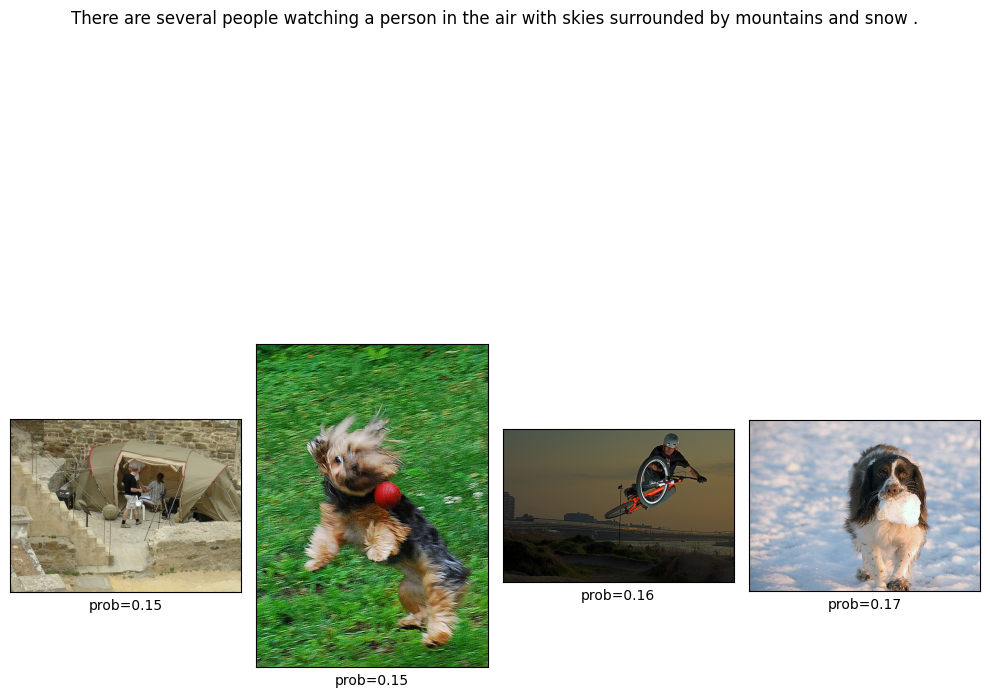

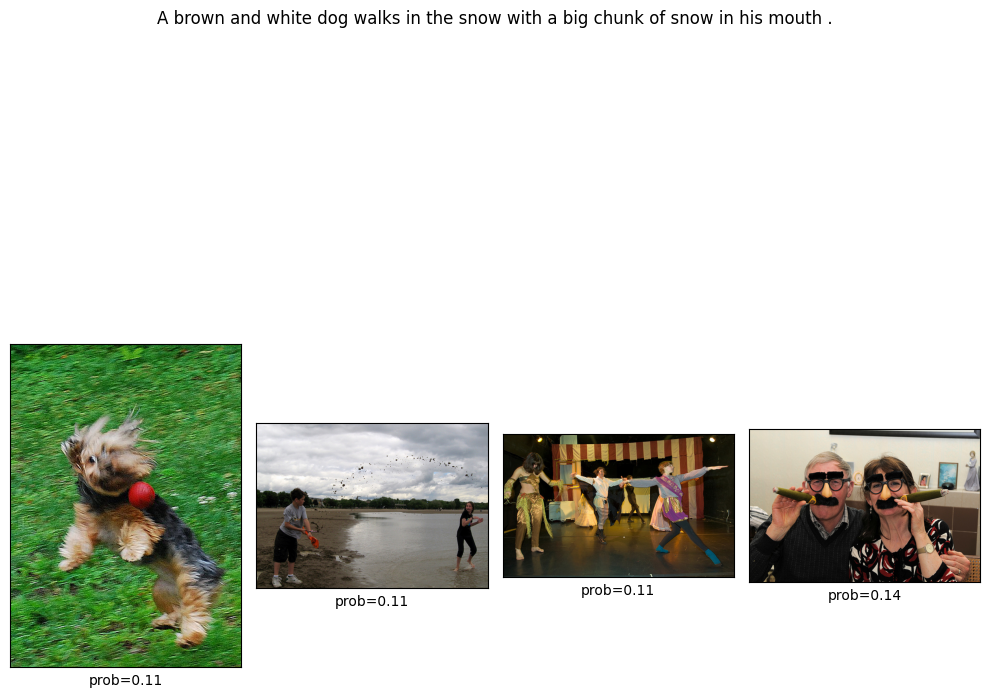

This image is unavailable in your country in compliance with local laws.


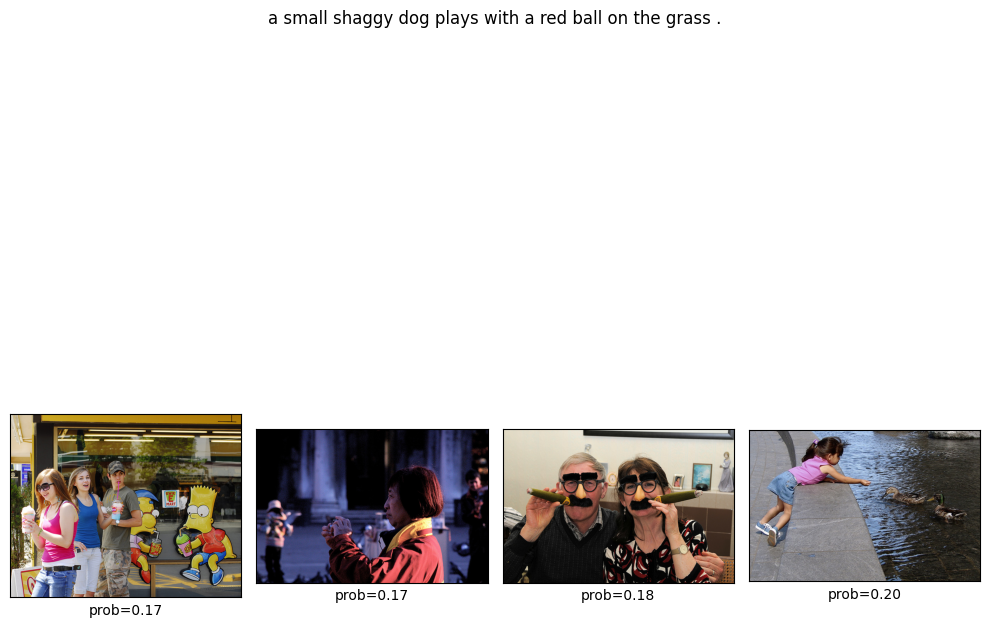

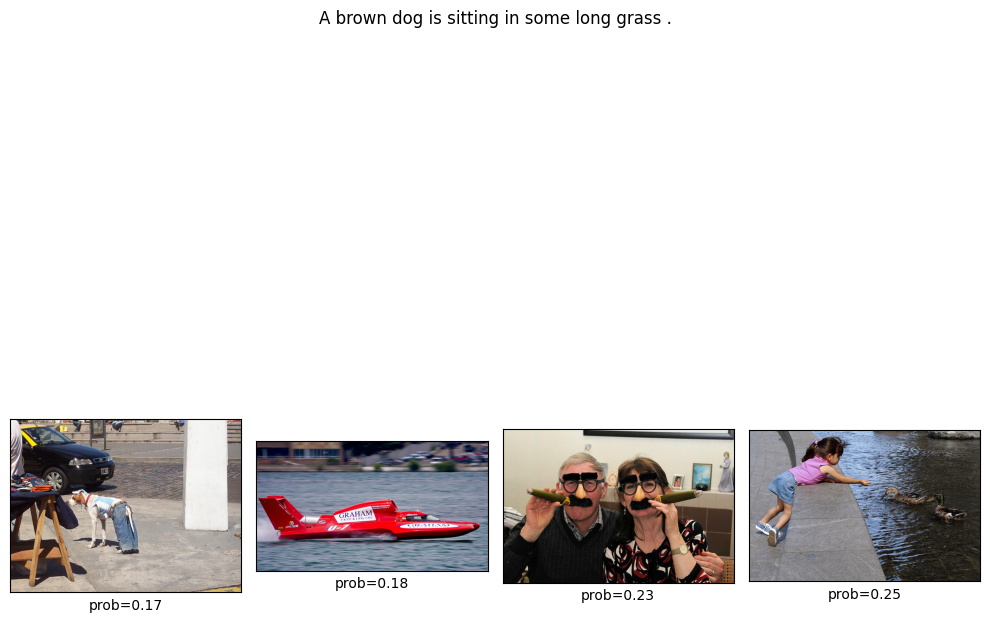

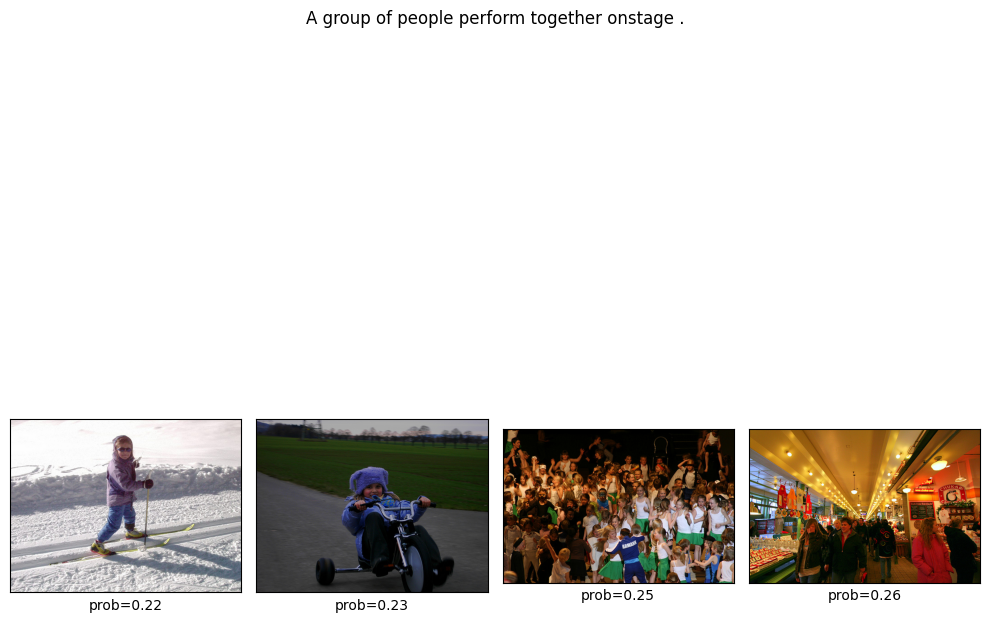

This image is unavailable in your country in compliance with local laws.


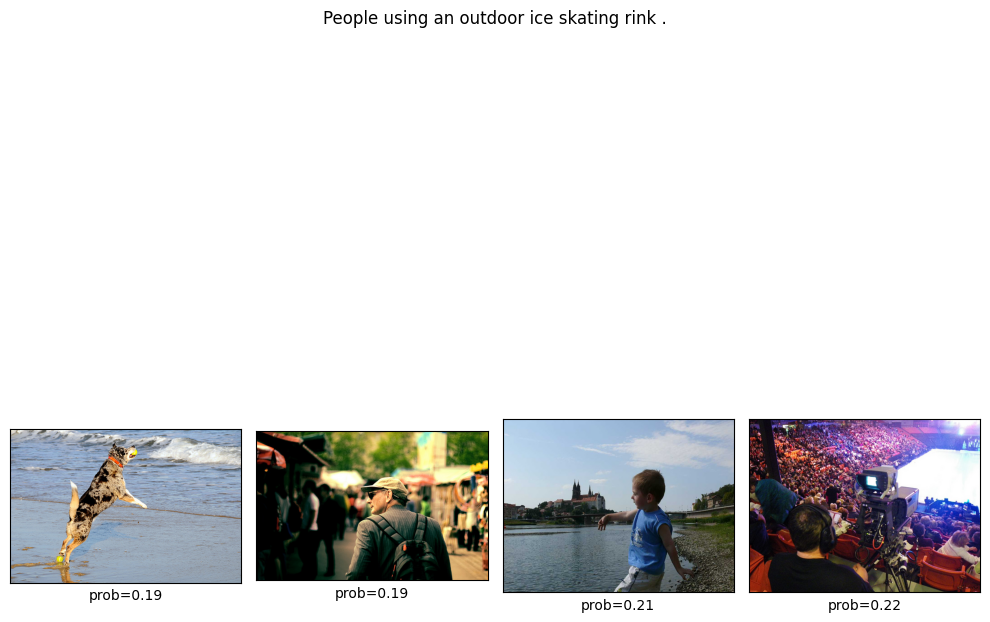

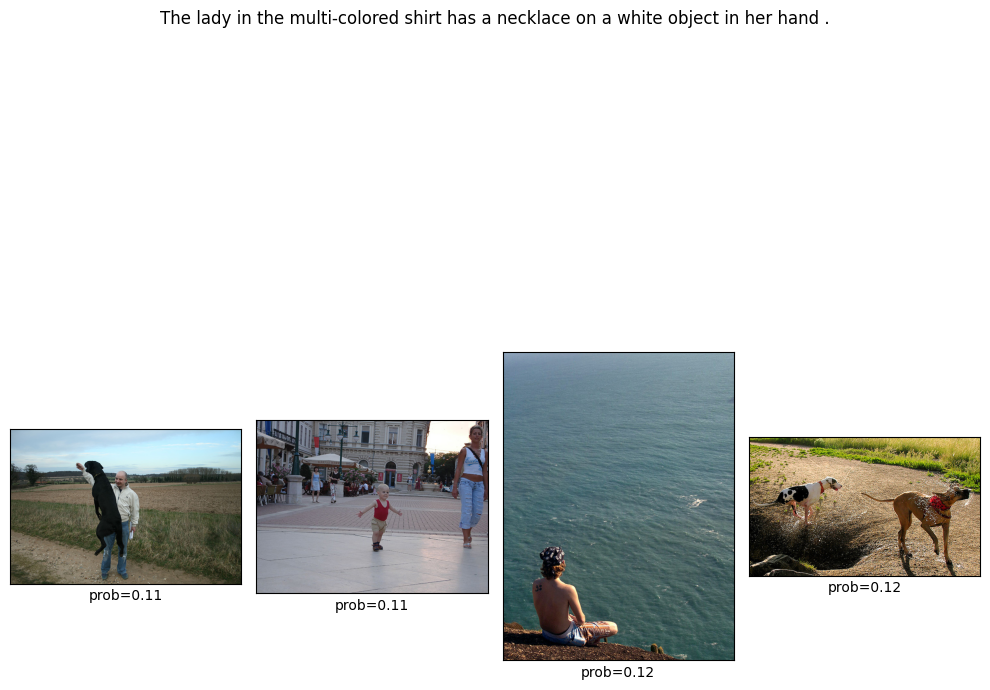

In [80]:
random_queries = test_df['query_text'].sample(10, random_state=0)

# Применяем функцию для 10 случайных запросов
for query in random_queries:
    show_picture(query)

## Вывод:
В процессе подготовки проекта было сделано следующие:  
* Первичный анализ данных показал явный перекос в сторону оценок, полученных за счёт краудсорсинга.
* Была выполнена агрегация и нормализация оценок экспертов. Использовали медианное значение и минимум-максимум нормализацию.
* Для оценок краудсорсинга использовали значение доли людей подтвердивших, что описание соответствует изображению.
* При объединении таблиц было принято решение сохранить все типы оценок.
* Для создания целевой переменной больший вес был дан экспертной оценки, так как данная оценка вызывает больше доверия.

Была обнаружена первая существенная проблема в данных – перекос распределения целевой переменной. Т.е. очень мало оценок хорошего соответствия изображения описанию.  

Обязательным условием было отфильтровать изображения, на которых есть дети. Для этого был создан словарь, фильтрация происходила уже после лемматизации текста.
После фильтрации в данных осталась 710 уникальных изображений, против 1000 изначальных.

Для векторизации изображений использовали ResNet-18.
Для векторизации текстов SpaCY.

Было взято пять моделей для обучения. В качестве метрики использовали RMSE.
Лучший результат показала модель SVR, RMSE = 0.202, при этом базовая модель показывает результат 0.236. Таким образом, разрыв между моделями минимален.

Тестирование модели показало очень посредственный результат. Визуальный анализ качества поиска показывает, что модель назначает оценки случайным образом.

Основные проблемы и способы решения:  
* Очень большой перекос в количестве данных в сторону оценок краудсорсинга. Способ решения:
Обучить модель только на оценках экспертов. Или сделать одинаковые выборки оценок экспертов и краудсорсинга, т.е. включить в модель только те описания, для которых есть оценки в обоих группах.
* Малое количество оценок, которые указывали бы на хорошее соответствие изображения тексту. Возможно, решается работой только с оценками экспертов.
* Слабая работа нейронной сети.
Возможно, поможет более сложная и глубокая настройка.
* Слишком хорошее соответствие данных в тестовой выборке




## Реализация CLIP

In [10]:
# загружаем модель
clip_model = SentenceTransformer("clip-ViT-B-32")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [11]:
# векторизуем картинки
def clip_image_embeddings(image_names, image_folder):
  embeddings = []
  for img_name in image_names:
    img_path = os.path.join(image_folder, img_name)
    img = Image.open(img_path)
    emb = clip_model.encode(img)
    embeddings.append(emb)
  return np.array(embeddings)

In [12]:
clip_test_image_path = os.path.join(data_path, "test_images")
clip_test_images = test_df['image']
clip_test_image_embeddings = clip_image_embeddings(clip_test_images.unique(), clip_test_image_path)

In [13]:
clip_test_image_embeddings.shape

(100, 512)

In [34]:
def clip_show_picture(text):
    lemmatized = lemmatize(text)
    if any(word in keywords_dic for word in lemmatized.split()):
        print("This image is unavailable in your country in compliance with local laws.")
        return
    # Векторизуем текст
    text_embedding = clip_model.encode([lemmatized], convert_to_tensor=True, show_progress_bar=False)

    # семантический поиск - сравнение векторов текста со всеми изображениями
    hits = util.semantic_search(text_embedding, clip_test_image_embeddings, top_k=4)[0]

    # Отображение изображений
    fig, axs = plt.subplots(1, 4, figsize=(8, 8))
    fig.suptitle(text)

    for i, ax in enumerate(axs.flat):
        idx = hits[i]["corpus_id"]
        score = hits[i]["score"]
        #img_name = clip_test_images.values[idx].item()
        img_name = clip_test_images.unique()[idx]
        img = Image.open(os.path.join(clip_test_image_path, img_name))
        ax.imshow(img)
        ax.set_title(f"Score: {score:.2f}")

    plt.tight_layout()
    plt.show()

This image is unavailable in your country in compliance with local laws.
This image is unavailable in your country in compliance with local laws.


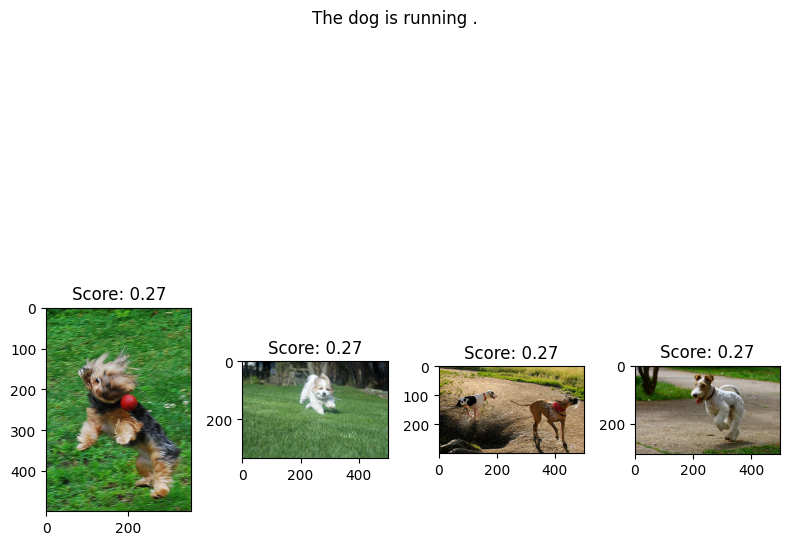

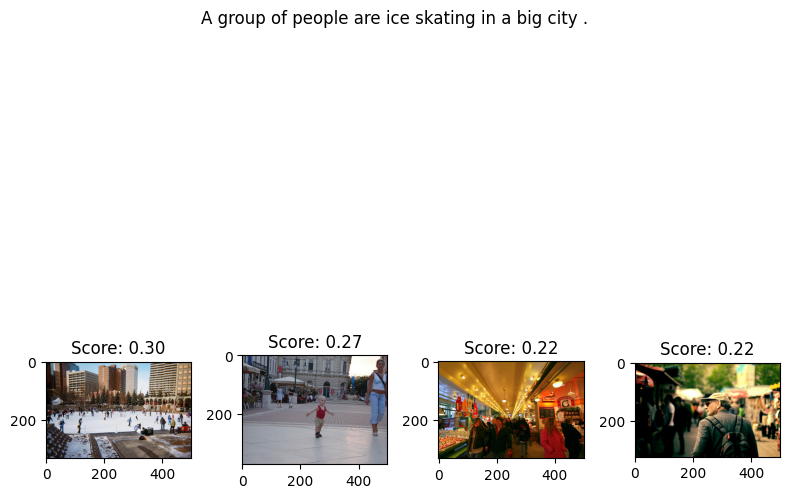

This image is unavailable in your country in compliance with local laws.


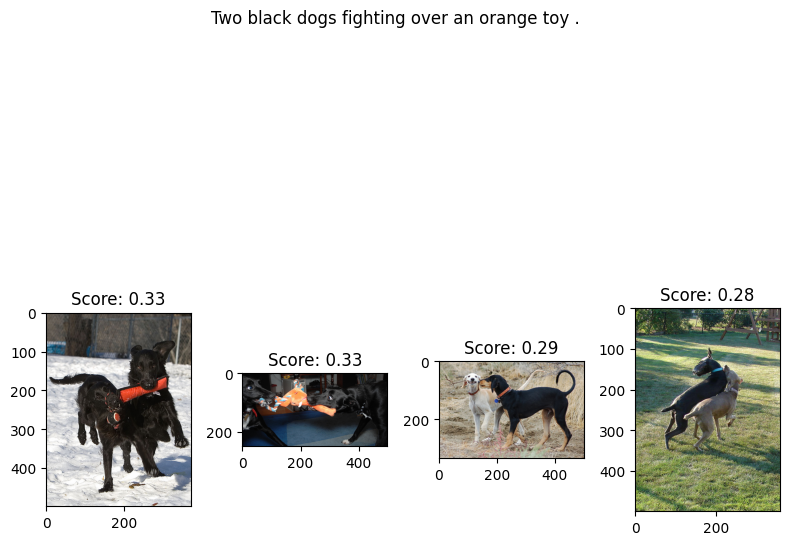

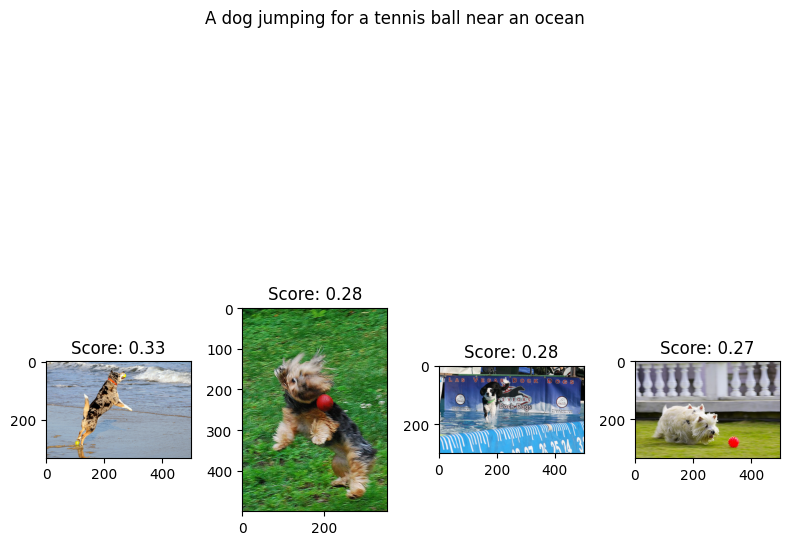

This image is unavailable in your country in compliance with local laws.
This image is unavailable in your country in compliance with local laws.
This image is unavailable in your country in compliance with local laws.


In [35]:
clip_random_queries = test_df['query_text'].sample(10, random_state=42)

for query in clip_random_queries:
    clip_show_picture(query)

Данный поход работает лучше, чем подход реализованный через модели. Наибольшую оценку (косинусная похожесть) получает картинка соответствующая изображению.